### Taxi trip duration prediction

- context is We train model on January's trips data where start and end time of trip is given, so based on this we will predict the estimated trip duration for February's month data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("data/green_tripdata_2025-01.parquet")

### Data Analysis

In [3]:
# number of vendorId's in that column
df["VendorID"].value_counts()

VendorID
2    42054
1     6272
Name: count, dtype: int64

In [4]:
# max tip amount in tip_amount column
df["tip_amount"].max()

252.05

In [5]:
# max tip amount in tip_amount column
df["tip_amount"].max()

252.05

In [6]:
# trip details of row with maximun tip
max_tip = df["tip_amount"].max()
#df[df["tip_amount"] == max_tip]

# to print it better 
row_max_tip = df[df["tip_amount"] == max_tip].iloc[0]
row_max_tip

VendorID                                   2
lpep_pickup_datetime     2025-01-18 01:50:08
lpep_dropoff_datetime    2025-01-18 02:17:22
store_and_fwd_flag                         N
RatecodeID                               1.0
PULocationID                              80
DOLocationID                             162
passenger_count                          1.0
trip_distance                           7.57
fare_amount                             35.2
extra                                    1.0
mta_tax                                  0.5
tip_amount                            252.05
tolls_amount                             0.0
ehail_fee                                NaN
improvement_surcharge                    1.0
total_amount                          293.25
payment_type                             1.0
trip_type                                1.0
congestion_surcharge                    2.75
cbd_congestion_fee                      0.75
Name: 25249, dtype: object

In [7]:
# trip details of row with maximun trip distance
max_distance = df["trip_distance"].max()

# to print it better 
row_max_dist = df[df["trip_distance"] == max_distance].iloc[0]
row_max_dist

VendorID                                   2
lpep_pickup_datetime     2025-01-08 15:20:00
lpep_dropoff_datetime    2025-01-08 15:23:00
store_and_fwd_flag                      None
RatecodeID                               NaN
PULocationID                               7
DOLocationID                             193
passenger_count                          NaN
trip_distance                       84731.57
fare_amount                            13.02
extra                                    0.0
mta_tax                                  0.5
tip_amount                               2.9
tolls_amount                             0.0
ehail_fee                                NaN
improvement_surcharge                    1.0
total_amount                           17.42
payment_type                             NaN
trip_type                                NaN
congestion_surcharge                     NaN
cbd_congestion_fee                       NaN
Name: 46850, dtype: object

In [8]:
'''
# top 3 trip details of row with maximun trip distance
max_distance_3 = df.nlargest(3, "trip_distance")
#print(df.nlargest(5, "trip_distance"))

# to print it better 
for i, (j,row) in enumerate(max_distance_3.iterrows(),1):
    print(f'----Row{i}----')
    for val, col in row.items():
          print(f'{val}: {col}')
            
## From analysis we found that distance column is not accurate
'''

'\n# top 3 trip details of row with maximun trip distance\nmax_distance_3 = df.nlargest(3, "trip_distance")\n#print(df.nlargest(5, "trip_distance"))\n\n# to print it better \nfor i, (j,row) in enumerate(max_distance_3.iterrows(),1):\n    print(f\'----Row{i}----\')\n    for val, col in row.items():\n          print(f\'{val}: {col}\')\n            \n## From analysis we found that distance column is not accurate\n'

In [9]:
# total number of rows
number_rows = len(df)

In [10]:
# no. of rows with zero tip
zero_tip = (df["tip_amount"] == 0).sum()
print("No. of rows with zero tip",number_rows - zero_tip)

No. of rows with zero tip 31877


In [11]:
# null values count
df.isnull().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag        1836
RatecodeID                1836
PULocationID                 0
DOLocationID                 0
passenger_count           1836
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                48326
improvement_surcharge        0
total_amount                 0
payment_type              1836
trip_type                 1843
congestion_surcharge      1836
cbd_congestion_fee        1836
dtype: int64

In [12]:
#data types of Columns
df.dtypes

VendorID                          int32
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int32
DOLocationID                      int32
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
cbd_congestion_fee              float64
dtype: object

In [20]:
df["trip_duration"].describe(percentiles=[0.95,0.97,0.99])

count    48326.000000
mean        19.955195
std         93.924039
min          0.000000
50%         11.250000
95%         32.366667
97%         38.837500
99%         61.991667
max       1439.650000
Name: trip_duration, dtype: float64

In [21]:
# percentage of data falls between these criteria
((df.trip_duration >= 1) & (df.trip_duration <= 60)).mean()

0.9582212473616687

In [23]:
condi = df[((df.trip_duration >= 1) & (df.trip_duration <= 60))]
# condtioned rows - number of rows = remaining rows that are opted out in given condition < 1 and > 60
number_rows - len(condi)

2019

### Data preprocessing

In [13]:
# function to preprocess data for validation and test set

def read_df(filename):
    df = pd.read_parquet(filename)

    # finding duartion of trip
    df["trip_duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]

    # apply this to every row in trip_duration column
    df["trip_duration"] = df["trip_duration"].apply(lambda td: td.total_seconds()/60)

    df = df[((df.trip_duration >= 1) & (df.trip_duration <= 60))]

    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
df_train = read_df("data/green_tripdata_2025-01.parquet")
df_val = read_df("data/green_tripdata_2025-02.parquet")

In [15]:
len(df_train), len(df_val)

(46307, 44218)

In [17]:
from sklearn.feature_extraction import DictVectorizer

In [29]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()
 
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [30]:
target = 'trip_duration'
Y_train = df_train[target].values
Y_val = df_val[target].values

In [31]:
len(Y_train), len(Y_val)

(46307, 44218)

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import root_mean_squared_error

In [33]:
LR = LinearRegression()
LR.fit(X_train,Y_train)

y_pred = LR.predict(X_train)
mean_squared_error(Y_train, y_pred, squared=False)

6.704280605544523

In [34]:
y_pred_val = LR.predict(X_val)
mean_squared_error(Y_val, y_pred_val, squared=False)

7.257679200794926

/tmp/ipykernel_58594/3094861320.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='Predictions')
/tmp/ipykernel_58594/3094861320.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_train, label='Actual')


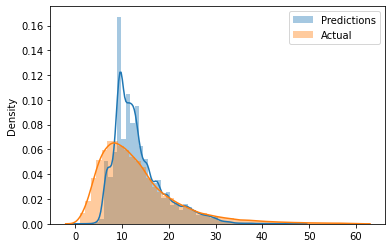

In [37]:
sns.distplot(y_pred, label='Predictions')
sns.distplot(Y_train, label='Actual')
plt.legend()
plt.show()

/tmp/ipykernel_58594/1618300889.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_val, label='Predictions')
/tmp/ipykernel_58594/1618300889.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_val, label='Actual')


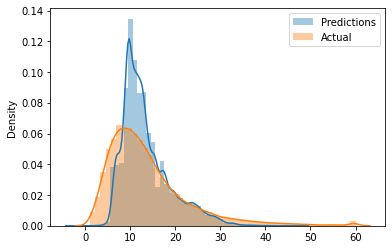

In [38]:
sns.distplot(y_pred_val, label='Predictions')
sns.distplot(Y_val, label='Actual')
plt.legend()
plt.show()

In [39]:
from sklearn.linear_model import Lasso

In [47]:
#LS = Lasso()
LS = Lasso(alpha=0.001)
LS.fit(X_train,Y_train)

y_pred_val_LS = LS.predict(X_val)
mean_squared_error(Y_val, y_pred_val_LS, squared=False)

7.267907833847719

In [41]:
from sklearn.linear_model import Ridge

In [42]:
RG = Ridge()
RG.fit(X_train,Y_train)

y_pred_val_RG = RG.predict(X_val)
mean_squared_error(Y_val, y_pred_val_RG, squared=False)

7.298735301390569

In [48]:
#saving the model
import pickle

In [50]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, LR), f_out)